# Mortality risk prediction

This tutorial will walk you through building a population-level risk prediction model from scratch, following the exact supervised framework outlined in your lecture.

**Our Goal**: Predict 1-year mortality for patients following their first adult ICU admission.

**Our Model**: We will use the L1-regularized logistic regression (LASSO) model mentioned in your slides to create a strong, interpretable baseline.

In [20]:
## Import libraries
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report,average_precision_score
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# 1. Load the data

In [21]:
data_path = "data/mimic IV/" ## Replace with your own path
patients = pd.read_csv(os.path.join(data_path,'patients.csv.gz'))
admissions = pd.read_csv(os.path.join(data_path,'admissions.csv.gz'))
icustays = pd.read_csv(os.path.join(data_path,'icustays.csv.gz'))
diagnoses = pd.read_csv(os.path.join(data_path,'diagnoses_icd.csv.gz'))
procedures = pd.read_csv(os.path.join(data_path,'procedures_icd.csv.gz'))

**Q1**: How many patients do you have in this dataset?

In [22]:
# Convert key columns to datetime objects ---
# This is crucial for temporal calculations
patients['dod'] = pd.to_datetime(patients['dod']) ##date of death
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])

In [23]:
# Get Patient Demographics (Age)
# We merge admissions and patients to get age at admission
admissions = admissions.merge(patients[['subject_id', 'anchor_age', 'anchor_year', 'dod']], on='subject_id')


# Calculate age. Note: This is an approximation based on MIMIC's anchoring.
admissions['age_at_admission'] = admissions['anchor_age'] + (pd.to_datetime(admissions['admittime']).dt.year - admissions['anchor_year'])

In [24]:
patients

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaT
2,10000058,F,33,2168,2020 - 2022,NaT
3,10000068,F,19,2160,2008 - 2010,NaT
4,10000084,M,72,2160,2017 - 2019,2161-02-13
...,...,...,...,...,...,...
364622,19999828,F,46,2147,2017 - 2019,NaT
364623,19999829,F,28,2186,2008 - 2010,NaT
364624,19999840,M,58,2164,2008 - 2010,2164-09-17
364625,19999914,F,49,2158,2017 - 2019,NaT


# Merge with image identifier

In [25]:
image_link = pd.read_csv('data/cxr-record-list.csv.gz')
image_metadata = pd.read_csv('data/mimic-cxr-2.0.0-metadata.csv.gz')
image_metadata['StudyDate'] = pd.to_datetime(image_metadata['StudyDate'], format='%Y%m%d')


In [26]:
image_link

,subject_id,study_id,dicom_id,path
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...
...,...,...,...,...
377105,19999733,57132437,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,files/p19/p19999733/s57132437/428e2c18-5721d8f...
377106,19999733,57132437,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,files/p19/p19999733/s57132437/58c403aa-35ff8bd...
377107,19999987,55368167,58766883-376a15ce-3b323a28-6af950a0-16b793bd,files/p19/p19999987/s55368167/58766883-376a15c...
377108,19999987,58621812,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,files/p19/p19999987/s58621812/7ba273af-3d290f8...


In [27]:
image_metadata

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,2180-05-06,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,2180-05-06,213014.531,CHEST (PA AND LAT),lateral,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,2180-06-26,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,CHEST (PA AND LAT),LATERAL,3056,2544,2180-06-26,165500.312,CHEST (PA AND LAT),lateral,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,2180-07-23,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
377105,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,19999733,57132437,CHEST (PA AND LAT),PA,3056,2544,2152-07-08,224550.171,CHEST (PA AND LAT),postero-anterior,Erect
377106,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,19999733,57132437,CHEST (PA AND LAT),LATERAL,3056,2544,2152-07-08,224550.171,CHEST (PA AND LAT),lateral,Erect
377107,58766883-376a15ce-3b323a28-6af950a0-16b793bd,19999987,55368167,CHEST (PORTABLE AP),AP,2544,3056,2145-11-04,51448.218,CHEST (PORTABLE AP),antero-posterior,Erect
377108,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,19999987,58621812,CHEST (PORTABLE AP),AP,3056,2544,2145-11-02,202809.234,CHEST (PORTABLE AP),antero-posterior,Erect


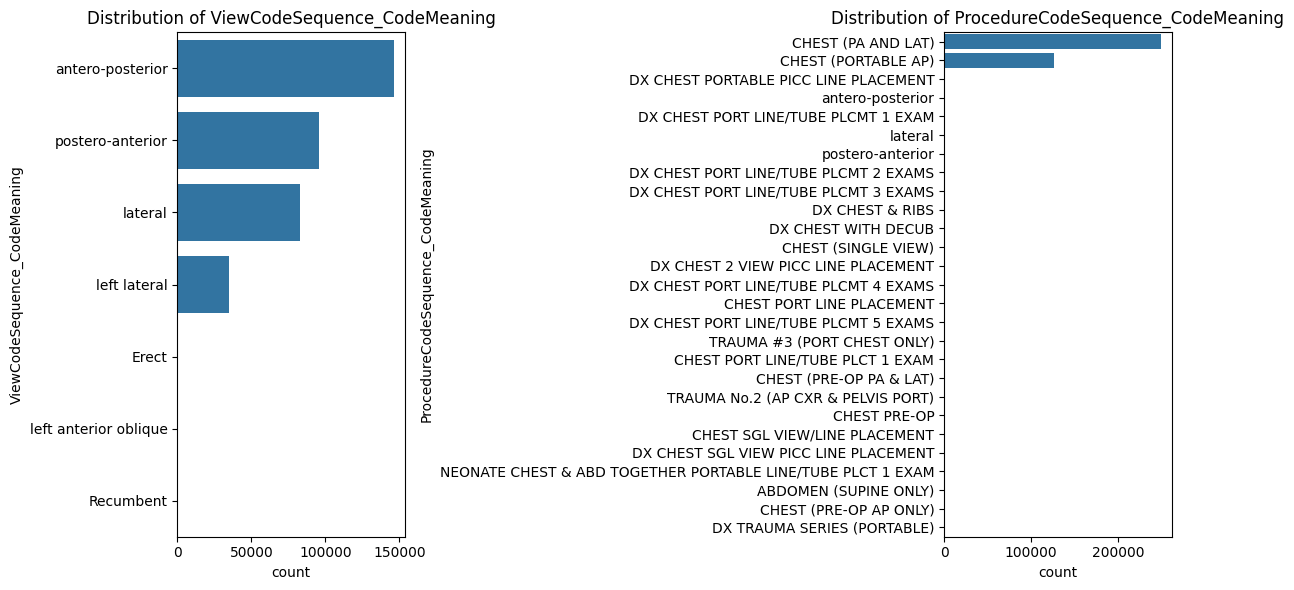

In [28]:
# plot distribution of 'ViewCodeSequence_CodeMeaning' and 'ProcedureCodeSequence_CodeMeaning'
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(y='ViewCodeSequence_CodeMeaning', data=image_metadata, order=image_metadata['ViewCodeSequence_CodeMeaning'].value_counts().index)
plt.title('Distribution of ViewCodeSequence_CodeMeaning')
plt.subplot(1,2,2)
sns.countplot(y='ProcedureCodeSequence_CodeMeaning', data=image_metadata, order=image_metadata['ProcedureCodeSequence_CodeMeaning'].value_counts().index)
plt.title('Distribution of ProcedureCodeSequence_CodeMeaning')
plt.tight_layout()  
plt.show()

In [29]:
# merge image_link with image_metadata to add StudyDate
image_link = image_link.merge(image_metadata[['dicom_id', 'StudyDate']], on='dicom_id', how='left')

In [30]:
image_link

,subject_id,study_id,dicom_id,path,StudyDate
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...,2180-05-06
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...,2180-05-06
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...,2180-06-26
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...,2180-06-26
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...,2180-07-23
...,...,...,...,...,...
377105,19999733,57132437,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,files/p19/p19999733/s57132437/428e2c18-5721d8f...,2152-07-08
377106,19999733,57132437,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,files/p19/p19999733/s57132437/58c403aa-35ff8bd...,2152-07-08
377107,19999987,55368167,58766883-376a15ce-3b323a28-6af950a0-16b793bd,files/p19/p19999987/s55368167/58766883-376a15c...,2145-11-04
377108,19999987,58621812,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,files/p19/p19999987/s58621812/7ba273af-3d290f8...,2145-11-02


In [31]:
# number of unique patients
print(f"Number of unique patients with CXR images: {image_link['subject_id'].nunique()}")

Number of unique patients with CXR images: 65379


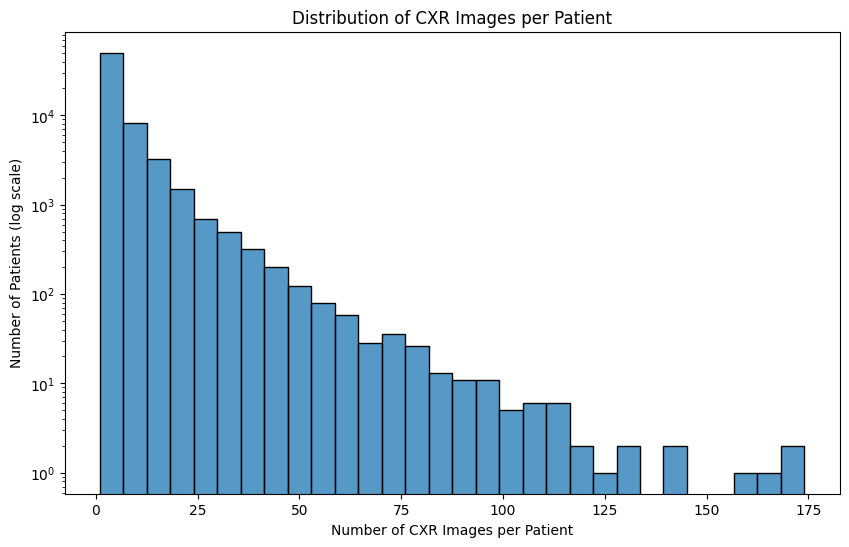

In [32]:
# distribution of number of CXR images per patient
image_counts = image_link['subject_id'].value_counts()
plt.figure(figsize=(10,6))
sns.histplot(image_counts, bins=30, kde=False)
plt.yscale('log')
plt.xlabel('Number of CXR Images per Patient')
plt.ylabel('Number of Patients (log scale)')
plt.title('Distribution of CXR Images per Patient')
plt.show()

# Merge patients with their dicom files

In [33]:
# merge image_link with patients
image_link = image_link.merge(patients[['subject_id', 'dod', 'gender']], on='subject_id', how='left')
image_link

,subject_id,study_id,dicom_id,path,StudyDate,dod,gender
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...,2180-05-06,2180-09-09,F
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...,2180-05-06,2180-09-09,F
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...,2180-06-26,2180-09-09,F
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...,2180-06-26,2180-09-09,F
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...,2180-07-23,2180-09-09,F
...,...,...,...,...,...,...,...
377105,19999733,57132437,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,files/p19/p19999733/s57132437/428e2c18-5721d8f...,2152-07-08,NaT,F
377106,19999733,57132437,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,files/p19/p19999733/s57132437/58c403aa-35ff8bd...,2152-07-08,NaT,F
377107,19999987,55368167,58766883-376a15ce-3b323a28-6af950a0-16b793bd,files/p19/p19999987/s55368167/58766883-376a15c...,2145-11-04,NaT,F
377108,19999987,58621812,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,files/p19/p19999987/s58621812/7ba273af-3d290f8...,2145-11-02,NaT,F


### Lets start and use only the first scan of each patient
### (the prediction task is therefore: survival prediction after first scan)

In [35]:
# for patients with multiple images, keep the earliest image
image_link = image_link.sort_values(by=['subject_id', 'StudyDate']).drop_duplicates(subset=['subject_id'], keep='first')

# replace .dcm with .tfrecord in the file_path
image_link['path'] = image_link['path'].str.replace('.dcm', '.tfrecord')

In [36]:
image_link

,subject_id,study_id,dicom_id,path,StudyDate,dod,gender
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...,2180-05-06,2180-09-09,F
7,10000764,57375967,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,files/p10/p10000764/s57375967/096052b7-d256dc4...,2132-10-15,NaT,M
12,10000898,54205396,8959e402-2175d68d-edba5a6c-baab51c3-9359f700,files/p10/p10000898/s54205396/8959e402-2175d68...,2188-01-13,NaT,F
22,10000935,56522600,6fa5997e-b1dfecf8-3c174666-8815c84a-32db59ff,files/p10/p10000935/s56522600/6fa5997e-b1dfecf...,2186-07-30,2187-11-12,F
39,10000980,59988438,57a3c797-7272b246-fa226777-e4c7d84c-91ec2e96,files/p10/p10000980/s59988438/57a3c797-7272b24...,2188-01-03,2193-08-26,F
...,...,...,...,...,...,...,...
377098,19999287,53282218,5a5eddf4-b64e5e49-f6e9c8bc-d6409b00-015470ea,files/p19/p19999287/s53282218/5a5eddf4-b64e5e4...,2196-11-27,2197-09-02,F
377101,19999376,57540554,53e9b6d0-5d5317f5-f1a4c031-01d40558-fd14a425,files/p19/p19999376/s57540554/53e9b6d0-5d5317f...,2145-07-31,NaT,M
377103,19999442,58708861,16b6c70f-6d36bd77-89d2fef4-9c4b8b0a-79c69135,files/p19/p19999442/s58708861/16b6c70f-6d36bd7...,2148-11-19,NaT,M
377104,19999733,57132437,3fcd0406-9b111603-feae7033-96632b3a-111333e5,files/p19/p19999733/s57132437/3fcd0406-9b11160...,2152-07-08,NaT,F


# Load the embeddings

In [18]:
root = '/Users/julian/Downloads/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0'

In [1]:
import tensorflow as tf

2025-12-05 14:45:45.589958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/julian/opt/anaconda3/envs/ehr/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [37]:
embedding_files = image_link['path'].apply(lambda x: os.path.join(root, x)).tolist()
raw_dataset = tf.data.TFRecordDataset(embedding_files)
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  embedding_vector = example.features.feature['embedding']

2025-12-05 14:50:25.422190: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [40]:
example

features {
  feature {
    key: "image/id"
    value {
      bytes_list {
        value: "gs://superrad/inputs/mimic-cxr/files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm"
      }
    }
  }
  feature {
    key: "image/format"
    value {
      bytes_list {
        value: "png"
      }
    }
  }
  feature {
    key: "embedding"
    value {
      float_list {
        value: 0.125710785
        value: -1.80300736
        value: 1.28425109
        value: -1.80883241
        value: 0.127820268
        value: -0.191195771
        value: 0.609272301
        value: 0.830579042
        value: -0.443789303
        value: 1.23889482
        value: -0.731681228
        value: -0.0466443636
        value: -0.0726856217
        value: -0.0915075
        value: 1.90368938
        value: 1.24945664
        value: -0.971235633
        value: 1.45406413
        value: 0.326573938
        value: 0.305792272
        value: 2.55911589
        value: 2.23971534
        value: -2

In [43]:
existing_files = [p for p in embedding_files if os.path.exists(p)]
missing_count = len(embedding_files) - len(existing_files)
print(f"TFRecord files: found {len(existing_files)}, skipped {missing_count} missing")

TFRecord files: found 40544, skipped 24835 missing


In [44]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm

embedding_files = existing_files

def parse_example(serialized):
    features = {
        "image/id": tf.io.FixedLenFeature([], tf.string),
        "embedding": tf.io.VarLenFeature(tf.float32),
    }
    parsed = tf.io.parse_single_example(serialized, features)
    image_id = parsed["image/id"]
    embedding = tf.sparse.to_dense(parsed["embedding"])
    return image_id, embedding

# Dataset pipeline: parallel map, batch and prefetch for efficiency
batch_size = 1024
ds = tf.data.TFRecordDataset(embedding_files)
ds = ds.map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(batch_size)
ds = ds.prefetch(tf.data.AUTOTUNE)

image_ids = []
embeddings = []

for batch_image_id, batch_embedding in ds:
    # convert to numpy; bytes -> str
    img_ids = batch_image_id.numpy().astype("U")  # convert bytes to str
    emb_np = batch_embedding.numpy()              # shape (B, emb_dim)
    image_ids.extend(img_ids.tolist())
    # store embeddings as lists (or keep as np arrays)
    embeddings.extend([e for e in emb_np])

# build DataFrame
df_embeddings = pd.DataFrame({"image_id": image_ids, "embedding": embeddings})

# Optional: expand embedding into separate numeric columns if needed
if len(df_embeddings) > 0:
    emb_dim = len(df_embeddings["embedding"].iloc[0])
    # if embedding dim is reasonable, expand
    if emb_dim > 0 and emb_dim <= 1024:  # adjust threshold as desired
        emb_arr = np.vstack(df_embeddings["embedding"].values)
        emb_cols = [f"emb_{i}" for i in range(emb_dim)]
        df_expanded = pd.concat([df_embeddings[["image_id"]].reset_index(drop=True),
                                 pd.DataFrame(emb_arr, columns=emb_cols)], axis=1)
    else:
        df_expanded = df_embeddings  # keep as is for very large dims


2025-12-05 15:01:23.543981: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [45]:
df_embeddings

,image_id,embedding
0,gs://superrad/inputs/mimic-cxr/files/p10/p1000...,"[0.12571079, -1.8030074, 1.2842511, -1.8088324..."
1,gs://superrad/inputs/mimic-cxr/files/p10/p1000...,"[-0.12371061, -1.2277083, 0.81394076, -1.62224..."
2,gs://superrad/inputs/mimic-cxr/files/p10/p1000...,"[-0.45668712, -1.995114, 0.7816418, -0.8419676..."
3,gs://superrad/inputs/mimic-cxr/files/p10/p1000...,"[-0.2708028, -0.53241235, 1.2457894, -2.023637..."
4,gs://superrad/inputs/mimic-cxr/files/p10/p1000...,"[0.8595034, -1.2872992, 1.0586625, -0.94367677..."
...,...,...
40539,gs://superrad/inputs/mimic-cxr/files/p19/p1999...,"[-0.7977255, -1.7351828, 1.238179, -1.6242267,..."
40540,gs://superrad/inputs/mimic-cxr/files/p19/p1999...,"[-0.017742615, -1.362272, 1.3281168, -1.148864..."
40541,gs://superrad/inputs/mimic-cxr/files/p19/p1999...,"[-0.046221904, -1.9575974, 0.65582377, -1.8325..."
40542,gs://superrad/inputs/mimic-cxr/files/p19/p1999...,"[0.08438494, -1.8283029, 0.80794024, -0.793702..."


# 2. Define the cohort
We want only adults, exclude patients who died in the hospital during their first icu visit

In [9]:
#take only adult
adult_admissions = admissions[admissions['age_at_admission'] >= 18]

# Merge with icustays
adult_icu = icustays.merge(adult_admissions, on=['subject_id', 'hadm_id'])

# Find the *first* icu stay for each patient
adult_icu = adult_icu.sort_values(by='intime')
first_icu_stays = adult_icu.groupby('subject_id').first().reset_index()

# Exclude patients who died in the hospital
# `deathtime` in the admissions table is the time of in-hospital death
cohort = first_icu_stays[first_icu_stays['deathtime'].isnull()].copy()

**Q3**: What is our index date?

In [11]:
cohort["index_date"] = #??

In [12]:
print(f"Initial cohort (first adult ICU stay): {len(first_icu_stays)}")
print(f"Final cohort (after excluding in-hospital deaths): {len(cohort)}")

Initial cohort (first adult ICU stay): 50914
Final cohort (after excluding in-hospital deaths): 43956


# 3. Define the Label
The label is True if the patient died within the 365-day prediction window after the index date.

In [13]:
cohort["time_to_death"] = (cohort['dod'] - cohort['index_date']).dt.days
cohort["time_to_death"] = cohort["time_to_death"].fillna(np.inf)  # alive patients → very large number
cohort['label_1yr_mortality'] = (cohort["time_to_death"] <= 365) & (cohort["time_to_death"] > 0)
final_cohort = cohort[['subject_id', 'hadm_id', 'index_date', 'label_1yr_mortality']]
print(final_cohort.head())

   subject_id   hadm_id          index_date  label_1yr_mortality
0    10000032  29079034 2180-07-23 23:50:47                 True
1    10000980  26913865 2189-06-27 20:38:27                False
2    10001217  24597018 2157-11-21 22:08:00                False
3    10001725  25563031 2110-04-12 23:59:56                False
5    10002013  23581541 2160-05-19 17:33:33                False


**Q4**: What is the prevalence in the cohort?

# 4. Create the raw count matrix

In [14]:
# We merge the diagnoses, procedure, prescription table with our final_cohort

cohort_diagnoses = diagnoses.merge(final_cohort[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'])
cohort_diagnoses["features"] = cohort_diagnoses["icd_code"].values

cohort_procedures =procedures.merge(final_cohort[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'])
cohort_procedures["features"] = cohort_procedures["icd_code"].values


# concat these tables
cohort_features = pd.concat([cohort_diagnoses[['subject_id', 'hadm_id', "features"]],
                            cohort_procedures[['subject_id', 'hadm_id', "features"]]])
cohort_features

,subject_id,hadm_id,features
0,10000032,29079034,45829
1,10000032,29079034,07044
2,10000032,29079034,7994
3,10000032,29079034,2761
4,10000032,29079034,78959
...,...,...,...
157761,19999828,25744818,0J980ZZ
157762,19999828,25744818,0WPF0JZ
157763,19999828,25744818,05HY33Z
157764,19999987,23865745,8841


In [ ]:
#  Create the "Raw Count Matrix"
# We only care about *presence* (binary), not the count, for this baseline
# Use pivot_table to create the matrix:
# Rows = subject_id, Columns = icd_code, Values = 1 (if present)
print("Building feature matrix...")
feature_matrix = cohort_features[["subject_id", "features"]].pivot_table(
    index='subject_id',
    columns='features',
    aggfunc=lambda x: 1,  # Fill with 1 if the code exists for the patient
    fill_value=0          # Fill with 0 otherwise
)

print(f"Feature matrix shape: {feature_matrix.shape}") # (n_patients, n_unique_icd_codes)

Building feature matrix...


In [ ]:
# Align Features (X) and Labels (y) ---
# Get the labels for the patients in our feature matrix
labels = final_cohort.set_index('subject_id').loc[feature_matrix.index]['label_1yr_mortality']

X = feature_matrix
y = labels

# 5. Model training/validation

In [ ]:
# Split Data into Train and Test Sets ---
# This is vital to prevent data leakage and evaluate the model properly
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=1,
    stratify=y  # Ensure same outcome prevalence in train/test
)

# Create a Scikit-learn Pipeline
# Remember, features *must* be standardized for LASSO to work correctly.
# A Pipeline bundles the scaler and the model together.

# We use 'liblinear' solver as it's good for L1 penalty.
# `C` is the *inverse* of regularization strength (lambda in your slide).
# A smaller C means *stronger* regularization (more features set to zero).
lasso_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        C=0.1,  # This is a hyperparameter you can tune
        random_state=42
    ))
])

# Train the Model
print("\nTraining the LASSO model...")
lasso_model.fit(X_train, y_train)
print("Model training complete.")


In [ ]:
# Evaluate on Test Set
y_pred_proba = lasso_model.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred_proba)
auprc = average_precision_score(y_test, y_pred_proba)
print(f"Test Set AUROC: {auroc:.4f}")
print(f"Test Set AUPRC: {auprc:.4f}")

# Show a classification report
y_pred = lasso_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['No Mortality', 'Mortality']))

**Q5**: What is the AUROC and AUPRC of this classification ?  

**Q6**: What do you think about these results?

**Q7**: How would you improve this prediction?

# 6. Model interpretation

In [ ]:
# Get the trained model and feature names
model = lasso_model.named_steps['model']
features = X_train.columns

# Create a DataFrame of features and their coefficients
coefficients = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_[0]
})


**Q8**: What are the top 5 most protective and adverse features?
(Hint: use the *d_icd_diagnoses* table to interpret ICD codes for better clinical understanding.)

# 7. Patient Stratification

In [ ]:
# Stratify Patients
print("\n--- Risk Stratification ---")
test_results = pd.DataFrame({
    'true_label': y_test,
    'predicted_prob': y_pred_proba
})

# Define risk groups based on predicted probability
# e.g., 'High Risk' = top 25% of predicted probabilities
quantile_threshold = test_results['predicted_prob'].quantile(0.75)
test_results['risk_group'] = 'Low Risk'
test_results.loc[test_results['predicted_prob'] >= quantile_threshold, 'risk_group'] = 'High Risk'

# Compare actual mortality rates between groups
stratification_summary = test_results.groupby('risk_group')['true_label'].agg(['mean', 'count'])
stratification_summary = stratification_summary.rename(columns={'mean': 'actual_mortality_rate'})

print(stratification_summary)

# 8. Bonus: plot the survival curves

In [ ]:
# Convert 1-year mortality label to integer (0 = alive, 1 = died)
cohort['event_observed'] = cohort['label_1yr_mortality'].values.astype(int)

# Define the duration for Kaplan-Meier:
# - If patient died within 1 year, use actual time to death
# - If patient survived, censor at 365 days
cohort['duration'] = np.where(
    cohort['label_1yr_mortality'].values,
    cohort['time_to_death'].values,
    365
)

# Ensure no duration is less than 1 day (KMF cannot handle zero duration)
cohort['duration'] = cohort['duration'].clip(lower=1)

# Merge the survival info with model predictions for plotting
merge_results = test_results.join(
    cohort[["subject_id", 'event_observed', "duration"]].set_index("subject_id")
)

# Create a Kaplan-Meier fitter and plotting axis
kmf = KaplanMeierFitter()
ax = plt.subplot(111)


# High-risk group
high_risk_data = merge_results[merge_results['risk_group'] == 'High Risk']
T_high = high_risk_data['duration']          # durations for high-risk patients
E_high = high_risk_data['event_observed']    # event indicators (0/1)
kmf.fit(T_high, event_observed=E_high, label='High Risk (Model)')
kmf.plot_survival_function(ax=ax)            # plot high-risk survival curve


# Low-risk group
low_risk_data = merge_results[merge_results['risk_group'] == 'Low Risk']
T_low = low_risk_data['duration']            # durations for low-risk patients
E_low = low_risk_data['event_observed']      # event indicators (0/1)
kmf.fit(T_low, event_observed=E_low, label='Low Risk (Model)')
kmf.plot_survival_function(ax=ax)            # plot low-risk survival curve


plt.title('Survival Plot by Predicted Risk Group')
plt.xlabel('Days After ICU Discharge (Prediction Window)')
plt.ylabel('Survival Probability')
plt.xlim(0, 365)  # Limit x-axis to 1-year window
plt.ylim(0.5, 1.0)  # Zoom in on region of interest to see separation
plt.grid()
plt.show()
